In [19]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import folium
from folium import plugins
from folium.plugins import MarkerCluster
from branca.colormap import LinearColormap
from matplotlib.colors import LinearSegmentedColormap
import branca.colormap as cmp
from sklearn.preprocessing import MinMaxScaler

In [20]:
# chemin d'accès des fichiers de données
DATA_PATH = 'https://github.com/dataforgoodfr/12_zero_dechet_sauvage/raw/2-nettoyage-et-augmentation-des-donn%C3%A9es/Exploration_visualisation/data/data_zds_enriched.csv'
CORRECTION = 'https://github.com/dataforgoodfr/12_zero_dechet_sauvage/raw/1-exploration-des-donn%C3%A9es/Exploration_visualisation/data/releves_corrects_surf_lineaire.xlsx'
DATA_SPOT = 'https://github.com/dataforgoodfr/12_zero_dechet_sauvage/raw/1-exploration-des-donn%C3%A9es/Exploration_visualisation/data/export_structures_29022024.xlsx'

# fichier geojson pour localisation folium
FRANCE_DPTS = "departements-version-simplifiee.geojson"
FRANCE_REGIONS = "regions-avec-outre-mer.geojson"

In [21]:
data = pd.read_csv(DATA_PATH)
correction = pd.read_excel('releves_corrects_surf_lineaire.xlsx')
correction = correction.rename(columns={'DEF_\nSURFACE': 'DEF_SURFACE'})
spot = pd.read_excel('export_spots_02042024.xlsx')

In [22]:
for df in [data, correction, spot]:
    
    display(df.head(3))
    print(f'Nombre de lignes : {df.shape[0]}')
    print(f'Nombre de colonnes : {df.shape[1]}')
    print('_____\n')

,ID_RELEVE,LIEU_PAYS,LIEU_REGION,LIEU_DEPT,LIEU_VILLE,LIEU_CODE_POSTAL,LIEU_COORD_GPS,LIEU_COORD_GPS_X,LIEU_COORD_GPS_Y,NOM_ZONE,...,INSEE_COM,DEP,REG,EPCI,NATURE_EPCI,BV2022,LIBEPCI,DEPARTEMENT,REGION,BASSIN_DE_VIE
0,12,France,Provence-Alpes-Côte d'Azur,13.0,Marseille,13008.0,"[""5.3416741728752"",""43.213786286934""]",5.341674,43.213786,Anse de la Maronaise,...,13055,13,93,200054807,ME,13055,Métropole d'Aix-Marseille-Provence,Bouches-du-Rhône,Provence-Alpes-Côte d'Azur,Marseille
1,14,France,Provence-Alpes-Côte d'Azur,13.0,Marseille,13008.0,"[""5.3429503182801"",""43.213941067785""]",5.342950,43.213941,Anse de la Maronaise,...,13055,13,93,200054807,ME,13055,Métropole d'Aix-Marseille-Provence,Bouches-du-Rhône,Provence-Alpes-Côte d'Azur,Marseille
2,16,France,Provence-Alpes-Côte d'Azur,13.0,Cassis,13260.0,"[""5.5392828683314"",""43.226082263728""]",5.539283,43.226082,Vallat dres Brayes et bords des routes des ale...,...,13022,13,93,200054807,ME,13022,Métropole d'Aix-Marseille-Provence,Bouches-du-Rhône,Provence-Alpes-Côte d'Azur,Cassis


Nombre de lignes : 2791
Nombre de colonnes : 107
_____



,ID_RELEVE,DEF_LONGUEUR_LINEAIRE,DEF_SURFACE
0,3097,OUI,NON
1,3079,OUI,OUI
2,3096,OUI,OUI


Nombre de lignes : 1094
Nombre de colonnes : 3
_____



,ID,NOM,TYPES,DATE_CREATION,STATUT_PUBLICATION,URL,REGION,VILLE,CODE_POSTAL,STRUCTURES_ADOPTANTES_NOM,STRUCTURES_ADOPTANTES_ID,LATITUDE,LONGITUDE,GEOMETRIE,LINEAIRE,SURFACE,NB_RELEVE,NB_EVENEMENT,DATE_DERNIER_EVENEMENT
0,312,Intersport Val d’Oisans,Association;Collectivité et Gestionnaire,2024/03/19,publié,http://www.zero-dechet-sauvage.org/spots/inter...,Auvergne-Rhône-Alpes,Mont-de-Lans,38860.0,NaN,NaN,45.017221,6.125255,"{""type"":""FeatureCollection"",""features"":[{""type...",65.257650,701.418676,0,0,NaN
1,311,République,Association,2024/03/08,publié,http://www.zero-dechet-sauvage.org/spots/repub...,Provence-Alpes-Côte d'Azur,Fréjus,83700.0,Planète Actions,348,43.424082,6.759159,"{""type"":""FeatureCollection"",""features"":[{""type...",517.663961,38287.791055,31,36,2024/03/13
2,310,Beaurivage,Association,2024/03/08,publié,http://www.zero-dechet-sauvage.org/spots/beaur...,Provence-Alpes-Côte d'Azur,Saint-Raphaël,83700.0,Planète Actions,348,43.420112,6.769801,"{""type"":""FeatureCollection"",""features"":[{""type...",676.012874,31449.939198,6,7,2024/03/20


Nombre de lignes : 304
Nombre de colonnes : 19
_____



In [23]:
print(f'Nombre de lignes avant la fusion : {data.shape[0]}')
print('________\n')

# fusion et correction
data_corect = pd.merge(data, correction, on='ID_RELEVE', how='left')
data_corect = data_corect[data_corect['DEF_SURFACE'] == 'OUI']

print(f'Nombre de lignes avec surface correcte : {data_corect.shape[0]}')

Nombre de lignes avant la fusion : 2791
________

Nombre de lignes avec surface correcte : 795


In [24]:
duplicate_rows = data_corect[data_corect.duplicated(subset=['LIEU_COORD_GPS'], keep=False)]
duplicate_rows.shape

(111, 109)

In [25]:
data = data_corect[data_corect['VOLUME_TOTAL'] > 0]
data.shape

(787, 109)

C:\Users\diazj\AppData\Local\Temp\ipykernel_19592\974911583.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['DENSITE'] = data['VOLUME_TOTAL']/data['SURFACE']


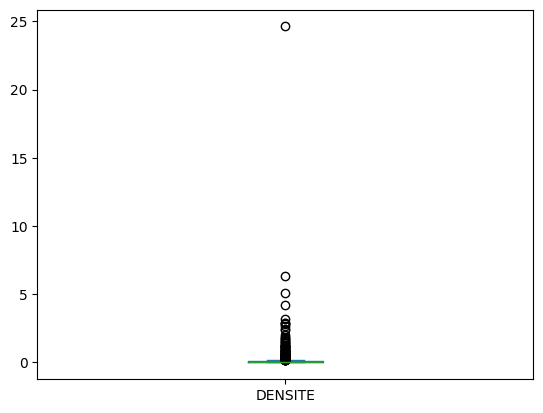

In [26]:
data['DENSITE'] = data['VOLUME_TOTAL']/data['SURFACE']
data['DENSITE'].plot(kind='box');

In [27]:
data[data['DENSITE'] > 20]

,ID_RELEVE,LIEU_PAYS,LIEU_REGION,LIEU_DEPT,LIEU_VILLE,LIEU_CODE_POSTAL,LIEU_COORD_GPS,LIEU_COORD_GPS_X,LIEU_COORD_GPS_Y,NOM_ZONE,...,EPCI,NATURE_EPCI,BV2022,LIBEPCI,DEPARTEMENT,REGION,BASSIN_DE_VIE,DEF_LONGUEUR_LINEAIRE,DEF_SURFACE,DENSITE
450,734,France,Provence-Alpes-Côte d'Azur,13.0,Châteauneuf-les-Martigues,13220.0,"[""5.1337349539444"",""43.399093687684""]",5.133735,43.399094,Mare de polystyrene. Chemin Carraire de Valamp...,...,200054807,ME,13054,Métropole d'Aix-Marseille-Provence,Bouches-du-Rhône,Provence-Alpes-Côte d'Azur,Marignane,Pas nécessaire,OUI,24.625127


In [28]:
data= data[data['DENSITE'] < 20]

## Cartes

In [29]:
data['TYPE_MILIEU'].unique()

array(['Littoral (terrestre)', 'Mer - Océan', "Cours d'eau",
       'Zone naturelle ou rurale (hors littoral et montagne)',
       'Zone urbaine', 'Lagune et étang côtier', 'Multi-lieux',
       'Montagne', 'Lac et Marais', 'Présent au sol (abandonné)'],
      dtype=object)

### Carte DENSITE

In [30]:
def couleur_milieu(type):
    couleur =  {
        'Littoral (terrestre)': 'lightblue',
        'Mer - Océan': 'darkblue',
        'Cours d\'eau': 'cyan',
        'Zone naturelle ou rurale (hors littoral et montagne)': 'green',
        'Zone urbaine': 'orange',
        'Lagune et étang côtier': 'red',
        'Multi-lieux': 'pink',
        'Montagne': 'grey',
        'Présent au sol (abandonné)': 'black'}
    return couleur.get(type, 'white')

In [31]:
gdf = gpd.read_file(FRANCE_REGIONS)


m = folium.Map(location=[data['LIEU_COORD_GPS_Y'].mean(), data['LIEU_COORD_GPS_X'].mean()])

for index, row in data.iterrows():

    color = couleur_milieu(row['TYPE_MILIEU'])

    folium.CircleMarker(
        location=[row['LIEU_COORD_GPS_Y'], row['LIEU_COORD_GPS_X']],
        radius=row['DENSITE']*10,  
        popup=f"Densité: {row['DENSITE']} L/m2 \n"
                f"Volume total : {row['VOLUME_TOTAL']}\n"
                f"Surface total : {row['SURFACE']}\n"
                f"Type de milieu : {row['TYPE_MILIEU']}",
        color=color,
        fill=True,
        
    ).add_to(m)

m

In [32]:
spot.ID.nunique()

304

In [33]:
data['SPOT_ID'].nunique()

107

In [34]:
gdf = gpd.read_file(FRANCE_REGIONS)


m = folium.Map(location=[spot['LATITUDE'].mean(), spot['LONGITUDE'].mean()]) # retravailler emplacement de départ 

for index, row in spot.iterrows():

    folium.CircleMarker(
        location=[row['LATITUDE'], row['LONGITUDE']],
        radius= 10,  
        popup=f"spot spot spot",
        color='blue',
        fill=True,
        fill_color='blue'
    ).add_to(m)

m

## Tableau

C:\Users\diazj\AppData\Local\Temp\ipykernel_19592\1275923719.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(df, x='DENSITE', y='TYPE_MILIEU', orient='h', palette= 'Reds_r')


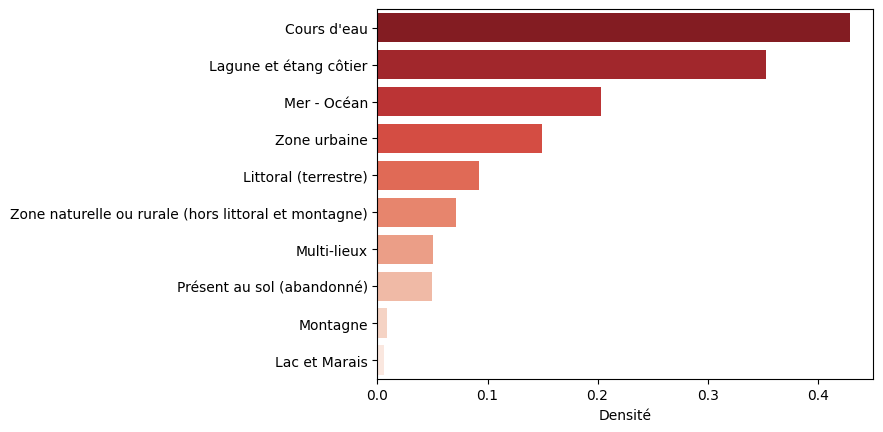

In [35]:

df = data.groupby('TYPE_MILIEU')['DENSITE'].mean().reset_index().sort_values(by='DENSITE', ascending=False)

sns.barplot(df, x='DENSITE', y='TYPE_MILIEU', orient='h', palette= 'Reds_r')
plt.ylabel('')
plt.xlabel('Densité');

del df

C:\Users\diazj\AppData\Local\Temp\ipykernel_19592\4093190751.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(df,x='count',y='TYPES', orient='h', palette='Blues_r')


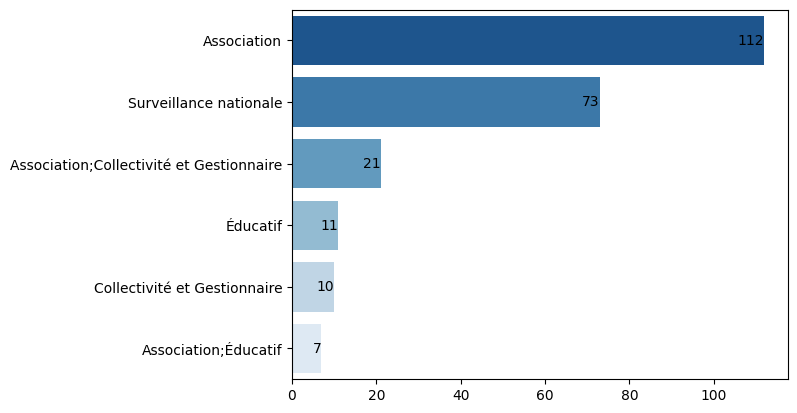

In [36]:
df = spot.groupby('TYPES').size().reset_index(name='count').sort_values(by='count',ascending=False)

sns.barplot(df,x='count',y='TYPES', orient='h', palette='Blues_r')
for index, row in df.iterrows():
    plt.text(x=row['count'], y=row['TYPES'], s=row['count'], va='center', ha='right')
plt.xlabel('')
plt.ylabel('');

del df